In [5]:
from hapiclient import hapi, hapitime2datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import calendar
from geopack import geopack
import datetime as datetime

In [ ]:
def fetch_omni_1min_data(params,data, start, stop):
    server      = 'https://cdaweb.gsfc.nasa.gov/hapi'
    dataset     = data
    parameters  = params
    data, meta  = hapi(server, dataset, parameters, start, stop)

    return data

In [ ]:
def extract_data(data, params):

    header = params.split(',')
    header.insert(0, 'Timestamp')

    #extract the data from the list
    extracted_data = [[x[i] for x in data] for i in range(len(header))]

    #create a dictionary and convert to dataframe using param names as headers
    df_dict = {header: values for header, values in zip(header, extracted_data)}
    df = pd.DataFrame(df_dict).set_index('Timestamp')

    #convert to datetime from '\b' time
    df.index = hapitime2datetime(df.index.values.astype(str))
    df.index = df.index.tz_convert("UTC").tz_convert(None)


    return df

In [ ]:
def extract_omni_1min(data, params):

    df = extract_data(data, params)
    df['Timestamp_1min_omni'] = df.index
    df['Timestamp_1hr_omni'] = pd.to_datetime(df['Timestamp_1min_omni'], errors='coerce').dt.floor('5h')
    df = df.reset_index(drop=True)
    
    return df


In [ ]:
omni_1min = "OMNI_HRO_5MIN"
omni_1min_params = 'percent_interp,BY_GSE,BZ_GSE,flow_speed,proton_density,T,Pressure,E,Mach_num,BSN_x,BSN_y,BSN_z'

#Pressure = flow pressure in nPa

yr = 2021
months = []
years = [2021,2022]
for year in years:
    for month in range(1,13):

        print('Processing: ',year, month)

        _, num_days = calendar.monthrange(year, month)

        start_time = f'{year}-{month:02d}-{1:02d}T00:00:000Z'
        end_time = f'{year}-{month:02d}-{num_days:02d}T23:59:59Z'

        #download the data then clean it
        omni_1min_data = fetch_omni_1min_data(omni_1min_params, omni_1min, start_time, end_time)
        omni_1min_df = extract_omni_1min(omni_1min_data, omni_1min_params)

        months.append(omni_1min_df)
        
months_df = pd.concat(months)
months_df = months_df.reset_index(drop=True)

export_path = f'/Users/sr2/OneDrive - University College London/PhD/Experiences/Postdocs/JSPS/Research/Analysis/Apr-24/data/omni/'
df_name = f'omni_hro_5min_2021-2022'
export_filename = export_path + df_name +'.csv'
months_df.to_csv(export_filename, index=False, header=True)
months_df
        

In [28]:
import_path=r'/Users/sr2/OneDrive - University College London/PhD/Experiences/Postdocs/JSPS/Research/Analysis/Apr-24/data/omni/omni_hro_5min_2021-2022.csv'
omni_df = pd.read_csv(import_path)
omni_df

,percent_interp,BY_GSE,BZ_GSE,flow_speed,proton_density,T,Pressure,E,Mach_num,BSN_x,BSN_y,BSN_z,Timestamp_1min_omni,Timestamp_1hr_omni
0,0,0.58,0.93,358.899994,4.51,34062.0,1.16,-0.39,13.4,14.38,-1.67,0.51,2021-01-01 00:00:00,2021-01-01 00:00:00
1,0,0.44,1.21,358.399994,4.22,34142.0,1.08,-0.46,12.3,14.50,-1.58,0.43,2021-01-01 00:05:00,2021-01-01 00:00:00
2,0,0.04,1.46,359.100006,4.41,33812.0,1.14,-0.51,12.5,14.43,-1.60,0.46,2021-01-01 00:10:00,2021-01-01 00:00:00
3,38,-0.52,1.43,359.899994,4.29,31964.0,1.11,-0.45,12.2,14.46,-1.48,0.39,2021-01-01 00:15:00,2021-01-01 00:00:00
4,92,-1.11,1.67,360.600006,4.36,28132.0,1.13,-0.51,12.5,14.45,-1.47,0.47,2021-01-01 00:20:00,2021-01-01 00:00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
210235,100,3.28,-0.87,572.799988,2.04,69130.0,1.34,0.01,7.3,13.50,-0.68,0.25,2022-12-31 23:35:00,2022-12-31 23:00:00
210236,100,3.04,-1.88,583.200012,2.54,92632.0,1.73,0.62,8.2,13.53,-0.52,-0.02,2022-12-31 23:40:00,2022-12-31 23:00:00
210237,100,2.70,-1.44,565.599976,2.31,66356.0,1.48,0.25,7.7,13.51,-0.72,-0.02,2022-12-31 23:45:00,2022-12-31 23:00:00
210238,100,2.35,0.47,572.099976,2.38,81531.0,1.55,-0.61,8.0,13.55,-0.78,0.31,2022-12-31 23:50:00,2022-12-31 23:00:00


In [29]:
def clean_omni(df):
    df = df.copy()
    df = df.dropna()

    #filters
    df = df[df['BY_GSE'] < 100]
    df = df[df['BZ_GSE'] < 100]
    df = df[df['flow_speed'] < 1400]
    df = df[df['proton_density'] < 150]
    df = df[df['T'] < 1e6]
    df = df[df['Pressure'] < 100]
    df = df[df['E'] < 100]
    df = df[df['Mach_num'] < 100]

    #new features
    df['Timestamp_1min_omni'] = pd.to_datetime(df['Timestamp_1min_omni'])
    df['doy'] = df['Timestamp_1min_omni'].dt.dayofyear
    
    def calculate_tilt_angle(row):
        t0 = datetime.datetime(1970, 1, 1)
        t1 = row['Timestamp_1min_omni']
        tdiff = (t1 - t0).total_seconds()
        tilt_angle = geopack.recalc(tdiff) # Calculate dipole tilt angle
        
        return tilt_angle
    
    df['tilt_angle'] = df.apply(calculate_tilt_angle, axis=1)

    #interpolate missing values
    df = df.interpolate()
    df = df.drop(columns=['percent_interp','Timestamp_1hr_omni','BSN_y','BSN_z'])


    return df

omni_df = clean_omni(omni_df)
omni_df

/var/folders/n2/t9qn3_vj3nd6jb505jq_l8dw0000gn/T/ipykernel_26285/1656434463.py:30: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df = df.interpolate()


,BY_GSE,BZ_GSE,flow_speed,proton_density,T,Pressure,E,Mach_num,BSN_x,Timestamp_1min_omni,doy,tilt_angle
0,0.58,0.93,358.899994,4.51,34062.0,1.16,-0.39,13.4,14.38,2021-01-01 00:00:00,1,-0.442220
1,0.44,1.21,358.399994,4.22,34142.0,1.08,-0.46,12.3,14.50,2021-01-01 00:05:00,1,-0.445671
2,0.04,1.46,359.100006,4.41,33812.0,1.14,-0.51,12.5,14.43,2021-01-01 00:10:00,1,-0.449104
3,-0.52,1.43,359.899994,4.29,31964.0,1.11,-0.45,12.2,14.46,2021-01-01 00:15:00,1,-0.452517
4,-1.11,1.67,360.600006,4.36,28132.0,1.13,-0.51,12.5,14.45,2021-01-01 00:20:00,1,-0.455908
...,...,...,...,...,...,...,...,...,...,...,...,...
210235,3.28,-0.87,572.799988,2.04,69130.0,1.34,0.01,7.3,13.50,2022-12-31 23:35:00,365,-0.425436
210236,3.04,-1.88,583.200012,2.54,92632.0,1.73,0.62,8.2,13.53,2022-12-31 23:40:00,365,-0.428916
210237,2.70,-1.44,565.599976,2.31,66356.0,1.48,0.25,7.7,13.51,2022-12-31 23:45:00,365,-0.432386
210238,2.35,0.47,572.099976,2.38,81531.0,1.55,-0.61,8.0,13.55,2022-12-31 23:50:00,365,-0.435845


In [ ]:
#Read MHD dates and expand-out the date ranges
mhd_data = pd.read_csv('mhd_dates.csv')
expanded_dt = pd.concat([pd.Series(pd.date_range(start, end)) 
        for start, end in zip(mhd_data['start'], mhd_data['end'])])

time = np.arange(288) #24hrs in 5min intervals
dt = [] 
for day in expanded_dt:
    for t in time:
        dt.append(day + pd.Timedelta(minutes=t*5)) #add 5min intervals to each day
dt = np.array(dt) #convert from list to numpy array
mhd_dates = pd.DataFrame({'Timestamp_1min_omni': dt}) 
mhd_dates

,Timestamp_1min_omni
0,2021-05-10 00:00:00
1,2021-05-10 00:05:00
2,2021-05-10 00:10:00
3,2021-05-10 00:15:00
4,2021-05-10 00:20:00
...,...
45787,2022-07-31 23:35:00
45788,2022-07-31 23:40:00
45789,2022-07-31 23:45:00
45790,2022-07-31 23:50:00


In [14]:
omni_mhd_dt_merged = pd.merge(mhd_dates, omni_df, on='Timestamp_1min_omni', how='left')
omni_mhd_dt_merged.rename(columns={'Timestamp_1min_omni':'dt'}, inplace=True)
omni_mhd_dt_merged.sort_values(by='dt', inplace=True)
omni_mhd_dt_merged

,dt,BY_GSE,BZ_GSE,flow_speed,proton_density,T,Pressure,E,Mach_num,BSN_x,doy,tilt_angle
0,2021-05-10 00:00:00,4.72,6.24,344.000000,12.11,24568.0,2.87,-2.63,7.3,12.82,130.0,0.253032
1,2021-05-10 00:05:00,4.35,6.55,344.799988,11.44,19841.0,2.72,-2.68,7.0,12.85,130.0,0.249749
2,2021-05-10 00:10:00,4.61,6.56,345.500000,12.65,25205.0,3.02,-2.73,7.3,12.72,130.0,0.246494
3,2021-05-10 00:15:00,4.65,6.89,344.700012,12.63,24265.0,3.00,-2.82,7.1,12.73,130.0,0.243269
4,2021-05-10 00:20:00,4.88,7.34,345.000000,12.47,23752.0,2.97,-3.00,6.8,12.79,130.0,0.240075
...,...,...,...,...,...,...,...,...,...,...,...,...
14971,2022-08-19 23:35:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14972,2022-08-19 23:40:00,-2.49,-4.47,655.700012,6.22,369026.0,5.35,2.58,15.2,10.74,231.0,0.183724
14973,2022-08-19 23:45:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14974,2022-08-19 23:50:00,-2.04,-4.64,653.299988,5.59,272819.0,4.77,2.74,14.0,10.92,231.0,0.176873


In [15]:
#export omni_mhd_dt_merged
export_path = f'/Users/sr2/OneDrive - University College London/PhD/Experiences/Postdocs/JSPS/Research/Analysis/Apr-24/data/omni/'
df_name = f'omni_mhd_1min'
export_filename = export_path + df_name +'.csv'
omni_mhd_dt_merged.to_csv(export_filename, index=False, header=True)


In [26]:
#show nan values
nan_values = omni_mhd_dt_merged[omni_mhd_dt_merged.isna().any(axis=1)]
nan_values.sort_values(by='dt')

,dt,BY_GSE,BZ_GSE,flow_speed,proton_density,T,Pressure,E,Mach_num,BSN_x,doy,tilt_angle
167,2021-05-10 13:55:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
297,2021-05-11 00:45:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
305,2021-05-11 01:25:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
314,2021-05-11 02:10:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
413,2021-05-11 10:25:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
14967,2022-08-19 23:15:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14969,2022-08-19 23:25:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14970,2022-08-19 23:30:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
14971,2022-08-19 23:35:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Plots are below. Not part of main code

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))
omni_df.hist(ax=ax)
plt.tight_layout()

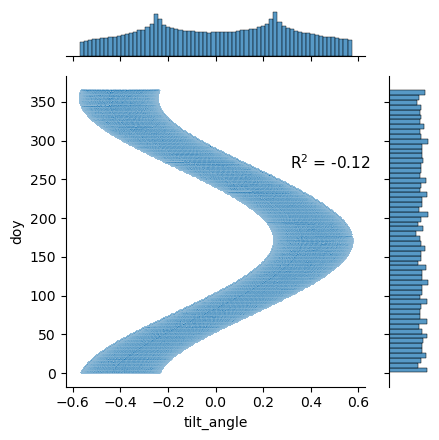

In [22]:
y = omni_df['doy']
x = omni_df['tilt_angle']
r2 = x.corr(y)
sns.jointplot(x=x, y=y, kind='scatter', s=1, height=4.5)
RE = r'R$_E$'
pcc = r'cm$^{-3}$'
#plt.xlabel(f'Proton Density [{pcc}]')
#plt.ylabel(f'Bow Shock Nose Location (GSE-X) [{RE}]')
#plt.xlabel('Pressure [nPa]')

#plt.ylabel('Electric Field [mV/m]')
#plt.xlabel('Bz [nT]')

r2_lab = r'R$^2$'    
annotation = f'{r2_lab} = {r2:.2f}'
plt.annotate(annotation, xy=(0.75, 0.7), xycoords='axes fraction', fontsize=11)
plt.tight_layout()
plt.savefig('/Users/sr2/OneDrive - University College London/PhD/Experiences/Postdocs/JSPS/Research/Analysis/Apr-24/plots/omni/R2_tilt-angle_doy.png', dpi=300)

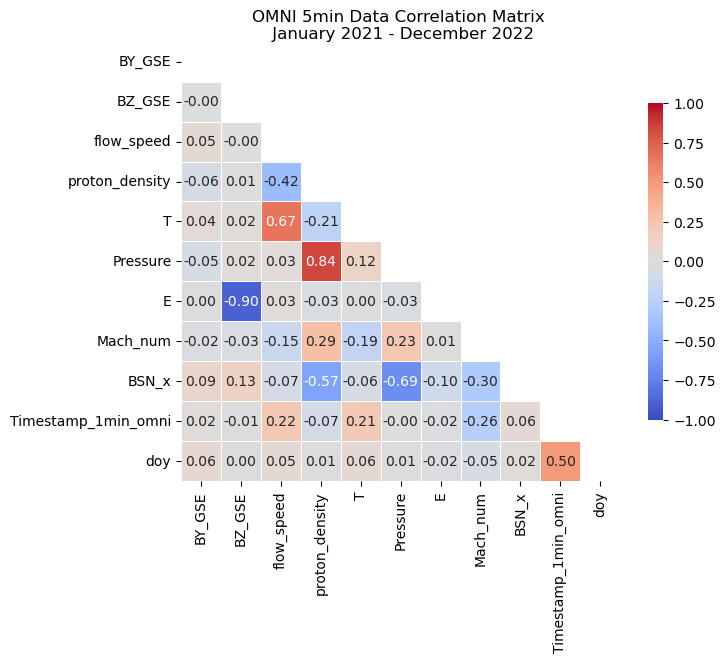

In [17]:
corr = omni_df.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(7.5, 6.5))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap='coolwarm', vmin=-1, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .7}, annot=True,
             fmt=".2f")

plt.title('OMNI 5min Data Correlation Matrix \n January 2021 - December 2022',pad=-40)
plt.tight_layout()
#plt.savefig('/Users/sr2/OneDrive - University College London/PhD/Experiences/Postdocs/JSPS/Research/Analysis/Apr-24/plots/omni/omni_heatmap.png', dpi=400)

,dt,BY_GSE,BZ_GSE,flow_speed,proton_density,T,Pressure,E,Mach_num,BSN_x,doy
0,2021-05-10 00:00:00,4.72,6.24,344.000000,12.11,24568.0,2.87,-2.63,7.3,12.82,130.0
1,2021-05-10 00:05:00,4.35,6.55,344.799988,11.44,19841.0,2.72,-2.68,7.0,12.85,130.0
2,2021-05-10 00:10:00,4.61,6.56,345.500000,12.65,25205.0,3.02,-2.73,7.3,12.72,130.0
3,2021-05-10 00:15:00,4.65,6.89,344.700012,12.63,24265.0,3.00,-2.82,7.1,12.73,130.0
4,2021-05-10 00:20:00,4.88,7.34,345.000000,12.47,23752.0,2.97,-3.00,6.8,12.79,130.0
...,...,...,...,...,...,...,...,...,...,...,...
45787,2022-07-31 23:35:00,-9.74,-1.25,451.500000,7.26,194335.0,2.96,0.12,6.0,12.55,212.0
45788,2022-07-31 23:40:00,-9.29,-0.53,442.899994,7.12,198561.0,2.79,-0.47,6.0,12.65,212.0
45789,2022-07-31 23:45:00,-8.77,-0.74,454.700012,8.03,233674.0,3.33,-0.07,6.6,12.43,212.0
45790,2022-07-31 23:50:00,-9.31,-4.03,465.000000,7.08,195292.0,3.06,1.33,5.9,12.03,212.0
